In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset
import numpy as np

from src.gan.generator import Generator
from src.gan.discriminator import Discriminator

from src.data_loaders.datasets.fashion_mnist_dataset import FashionMNISTDataset
from src.data_loaders.datasets.generated_fake_dataset import GeneratedFakeDataset
from src.data_loaders.datasource import show_images_from_tensor

In [35]:
device = torch.device("cuda:0")

In [36]:
#models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=40, output_dim=784).to(device)
discriminator = Discriminator(hidden_dim=256, input_dim=784).to(device)

In [37]:
fashionMNIST = FashionMNISTDataset()
train_data_real = fashionMNIST.train_data

generated_fake_dataset = GeneratedFakeDataset(generator, len(train_data_real))
train_data_fake = generated_fake_dataset.train_dataset

train_data_merged = torch.cat([train_data_real, train_data_fake], 0)

In [38]:
train_targets_real = fashionMNIST.get_train_set_targets()

train_targets_fake = generated_fake_dataset.get_train_set_targets()

train_targets_merged = torch.cat([train_targets_real, train_targets_fake], 0).unsqueeze(1)

In [39]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)
criterion = nn.MSELoss()

In [40]:
train_loader = data.DataLoader(TensorDataset(train_data_merged, train_targets_merged), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
# train_loader = data.DataLoader(TensorDataset(train_data_fake, train_targets_fake), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
# train_loader = data.DataLoader(TensorDataset(train_data_real, train_targets_real), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [41]:
def show_sample_predictions(discriminator, my_data_loader_batch):
    show_images_from_tensor(my_data_loader_batch[0].cpu())
    predictions = discriminator(my_data_loader_batch[0].to(device)).cpu()
    print(predictions)
    print(f"Loss: {criterion(predictions.cuda(), my_data_loader_batch[1].cuda())}")

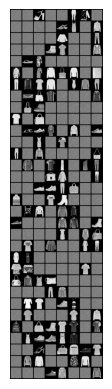

tensor([[0.0997],
        [0.0988],
        [0.0829],
        [0.1014],
        [0.0986],
        [0.0421],
        [0.0814],
        [0.0967],
        [0.1001],
        [0.0978],
        [0.1013],
        [0.1000],
        [0.0919],
        [0.0427],
        [0.0964],
        [0.0605],
        [0.1001],
        [0.0996],
        [0.1026],
        [0.0979],
        [0.0833],
        [0.0962],
        [0.1008],
        [0.0684],
        [0.1018],
        [0.0976],
        [0.0979],
        [0.1322],
        [0.0571],
        [0.0973],
        [0.0973],
        [0.0669],
        [0.1007],
        [0.0480],
        [0.0688],
        [0.0935],
        [0.0980],
        [0.1011],
        [0.1016],
        [0.0999],
        [0.0248],
        [0.0992],
        [0.0501],
        [0.0805],
        [0.0729],
        [0.1024],
        [0.0973],
        [0.1181],
        [0.0187],
        [0.0516],
        [0.0919],
        [0.1398],
        [0.1002],
        [0.0445],
        [0.0299],
        [0

In [42]:
show_sample_predictions(discriminator, next(iter(train_loader)))

In [43]:
num_epochs = 10
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_acc = []
    discriminator_error = []
    for i, batch in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        images = batch[0].to(device)
        b_size = images.size(0)
        # label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        label = batch[1].float().to(device)
        # Forward pass real batch through D
        output = discriminator(images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator = criterion(output, label)
        discriminator_error.append(error_discriminator.mean().item())
        # Calculate gradients for D in backward pass
        error_discriminator.backward()
        discriminator_acc.append(output.mean().item())
        # Update D
        discriminator_optimizer.step()
    print(f"Epoch: {epoch}, discriminator mean output: {np.mean(discriminator_acc):.3}")
    print(f"Epoch: {epoch}, discriminator mean error: {np.mean(discriminator_error):.3}")

C:\inz\nDES-thesis\venv\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, discriminator mean output: 0.484
Epoch: 0, discriminator mean error: 0.256
Epoch: 1, discriminator mean output: 0.495
Epoch: 1, discriminator mean error: 0.251
Epoch: 2, discriminator mean output: 0.496
Epoch: 2, discriminator mean error: 0.251
Epoch: 3, discriminator mean output: 0.498
Epoch: 3, discriminator mean error: 0.251
Epoch: 4, discriminator mean output: 0.498
Epoch: 4, discriminator mean error: 0.251
Epoch: 5, discriminator mean output: 0.499
Epoch: 5, discriminator mean error: 0.25
Epoch: 6, discriminator mean output: 0.498
Epoch: 6, discriminator mean error: 0.25
Epoch: 7, discriminator mean output: 0.499
Epoch: 7, discriminator mean error: 0.25
Epoch: 8, discriminator mean output: 0.5
Epoch: 8, discriminator mean error: 0.25
Epoch: 9, discriminator mean output: 0.498
Epoch: 9, discriminator mean error: 0.25


In [ ]:
show_sample_predictions(discriminator, next(iter(train_loader)))

In [ ]:
print(train_targets_fake)

In [47]:
print(train_targets_fake)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


# Wniosek -> dyskriminator się nie uczy nawet na zwykłym gradiencie